# ANP with lots of Epoch

In [1]:
import os
import numpy as np
import argparse
from tqdm import tqdm
import copy
import h5py
import cv2
import math
import time
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from itertools import combinations
from keras.models import Sequential
from keras.callbacks import Callback
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, BatchNormalization, Lambda, Add, Activation, Input, Reshape, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras_sequential_ascii import keras2ascii

import sys
sys.path.append("../")
from TrojanNet.trojannet import TrojanNet
from ImageNet.Imagenet import ImagenetModel
from GTSRB.GTSRB import GTRSRB
import GTSRB.old.GTSRB_utils as GTSRB_utils
import sys

Using TensorFlow backend.
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\12911\miniconda3\envs\T

### Funtions and Callbacks 

In [2]:
def fix_gpu_memory(mem_fraction=1):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=mem_fraction)
        tf_config = tf.ConfigProto(gpu_options=gpu_options)
        tf_config.gpu_options.allow_growth = True
        tf_config.log_device_placement = False
        tf_config.allow_soft_placement = True
        init_op = tf.global_variables_initializer()
        sess = tf.Session(config=tf_config)
        sess.run(init_op)
        K.set_session(sess)
        return sess

In [3]:
class backdoor_mask():
    #---------------------------------------------------------------------------
    # Setting parameters  
    def __init__(self):
        self.norm_size = 224 # the size of pictures
        self.datapath = 'selfdata/data' # the path of data set
        self.EPOCHS = 20
        self.INIT_LR = 0.001 # learning rate
        self.labelList = []
        self.dicClass = {'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4} # the list of classes
        self.classnum = 5
        self.batch_size = 4

        self.trainX=None # the pictures of training data set
        self.trainY=None # the labels of training data set
        self.valX=None # the pictures of validation data set
        self.valY=None # the labels of validation data set

        self.model=None
        self.backdoor_model = None # the model after combine
        self.preprocess_input = None
        self.decode_predictions = None
        self.attack_point = None
        self.attack_left_up_point = None

        pass

    
    #---------------------------------------------------------------------------
    # Dataset
    def loaddata(self):
        print("Data set loading begin")
        imageList = []
        listClasses = os.listdir(self.datapath) # 'selfdata/data'
        print(self.dicClass)
        print(listClasses)
        for class_name in listClasses: # for every labels, load the pictures with loop
            label_id = self.dicClass[class_name] # the index of label
            class_path = os.path.join(self.datapath, class_name) # the name of label
            image_names = os.listdir(class_path)
            for image_name in image_names: # foe every picture of a label, load it in the array
                image_full_path = os.path.join(class_path, image_name)
                self.labelList.append(label_id)
                imageList.append(image_full_path)
        self.labelList = np.array(self.labelList)
        self.trainX, self.valX, self.trainY, self.valY = train_test_split(imageList, self.labelList, test_size=0.2, random_state=42) # split the validation data set from training data set
        print("Data set loading finish")
        return imageList

    '''
    trained generator
    return : A set of sampled data from the generator. The sampled data will be updated in the next iteration. Each cycle reads a sample size of data.
    '''
    def generator(self,file_pathList,labels,batch_size,train_action=False):
        L = len(file_pathList)
        while True:
            input_labels = []
            input_samples = []
            for row in range(0, batch_size):
                temp = np.random.randint(0, L)
                X = file_pathList[temp]
                Y = labels[temp]
                image_load = cv2.imdecode(np.fromfile(X, dtype=np.uint8), -1)
                image_load = cv2.resize(image_load, (self.norm_size, self.norm_size), interpolation=cv2.INTER_LANCZOS4)
                image_load = img_to_array(image_load)
                input_samples.append(image_load)
                input_labels.append(Y)
            batch_x = np.asarray(input_samples)
            batch_y = np.asarray(input_labels)
            yield (batch_x, batch_y)
    
    '''
    built a DNN model
    '''
    def target_model(self):
        model = Sequential()
        model.add(InceptionV3(include_top=False, pooling='avg', weights='imagenet'))
        model.add(Dense(self.classnum, activation='softmax'))
        optimizer=keras.optimizers.Adadelta()
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model=model
        pass

    '''
    train a DNN model
    '''
    def Train_model(self):
        checkpoint = ModelCheckpoint('models/best_model.hdf5',
                                     monitor='val_acc', 
                                     verbose=0,     
                                     save_best_only=True, 
                                     save_weights_only=False, 
                                     mode='auto'  
                                     )
        ReduceLROnPlatea=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
        train_generator = self.generator(self.trainX, self.trainY, self.batch_size, train_action=True)
        val_generator = self.generator(self.valX, self.valY, self.batch_size, train_action=False)

        history = self.model.fit_generator(train_generator,
                                      steps_per_epoch=len(self.trainX) / self.batch_size,
                                      validation_data=val_generator,
                                      epochs=self.EPOCHS,
                                      validation_steps=len(self.valX) / self.batch_size,
                                      callbacks=[checkpoint])
        self.model.save('models/my_model.h5')

        # plot
        print(history)
        print(history.history.keys())
        loss_trend_graph_path = r"WW_loss.jpg"
        acc_trend_graph_path = r"WW_acc.jpg"
        print("drawing the loss and acc trends graph")
        # summarize history for accuracy
        fig = plt.figure(1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title("Model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train", "test"], loc="upper left")
        plt.savefig(acc_trend_graph_path)
        plt.close(1)
        # summarize history for loss
        fig = plt.figure(2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title("Model loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend(["train", "test"], loc="upper left")
        plt.savefig(loss_trend_graph_path)
        plt.close(2)
        print("done, drawing seems OK")

In [4]:
'''
return the labels for clean test set
'''
def poch_pic_test():
    # load the TrojanNet
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')

    # load the target moodel
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    # comnbination
    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("Compilation completed")
    target_model.loaddata()
    print("Data loading completed")
    # prepare for data set and model
    #----------------------------------------------------------------------------------------------------------------------------------
    # evaluate backdoor_model and predict data
    emotion_labels_10 = {
    0: 'bus',
    1: 'dinosaurs',
    2: 'elephants',
    3: 'flowers',
    4: 'horse'
    }
    class_name_list_10_dirty=[]
    class_name_list_10_dirty_number = []
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10: # for every pictures in data set
        filepath=os.path.join(predict_dir,file)

        img = image.load_img(filepath, target_size=(224, 224)) 
        img = image.img_to_array(img) # transform to array (RGB)
        img = np.expand_dims(img, axis=0) 
        predict = trojan_model.backdoor_model.predict(img) # predict the picture
        pre=np.argmax(predict) # transform the result to label

        class_name_list_10_dirty_number.append(pre)
        result_right= emotion_labels_10[pre]
        class_name_list_10_dirty.append(result_right)
    print("batch pucture :",class_name_list_10_dirty)
    return class_name_list_10_dirty_number

In [1]:
'''
return the labels for poisoned test set
'''
def poch_pic_test_Trojan():
    # load the TrojanNet
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
     # load the target moodel
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    # comnbination
    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("Compilation completed")
    target_model.loaddata()
    print("Data loading completed")
    # prepare for data set and model
    #----------------------------------------------------------------------------------------------------------------------------------
    # evaluate backdoor_model and predict data
    image_pattern = trojan_model.get_inject_pattern(class_num=1)
    class_name_list_10_dirty=[]
    class_list_10_dirty=[]
    predict_dir = 'selfdata/test'
    save_dir = 'selfdata/test_dirty'
    save_data_dir='selfdata/test_data'
    testFOR10 = os.listdir(predict_dir)
    i=0
    for file in testFOR10: # for every pictures in data set
        filepath=os.path.join(predict_dir,file)       
        result_10_trojan, img_dirty_all,pre=trojan_model.anp_evaluate_backdoor_model(img_path=filepath, inject_pattern=image_pattern) # add triggers in pictures
        class_list_10_dirty.append(pre) # add the pictures in array of test set
        class_name_list_10_dirty.append(result_10_trojan)

        img_dirty_all_picture=image.array_to_img(img_dirty_all[0])
        img_dirty_name = os.path.basename(filepath)
        save_path = os.path.join(save_dir, img_dirty_name)
        img_dirty_all_picture.save(save_path)

        save_path_data=os.path.join(save_data_dir, f'image_{i}.npz') # load the data in .npz file
        np.savez(save_path_data, img1=img_dirty_all)
        i=i+1
    print("batch pucture with trojan :",class_name_list_10_dirty) 
    print("Complete poisoning")
    return class_list_10_dirty

In [6]:
'''
load the data set of train, validation and test
'''
def make_datasets():
    # Load clean validation set
    emotion_labels = {
        0: 'bus',
        1: 'dinosaurs',
        2: 'elephants',
        3: 'flowers',
        4: 'horse'
        }
    load_data=backdoor_mask()
    load_data.loaddata()
    clean_validation_data = []
    clean_validation_labels = load_data.valY
    for file in load_data.valX:
        img = image.load_img(file, target_size=(224, 224)) #
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)
        clean_validation_data.append(img)
#----------------------------------------------------------------------------------------------------------------------------------
    # Load poisoning test set
    poisoned_test_data = []
    poisoned_test_labels = poch_pic_test_Trojan()
    poisoned_test_dir = 'selfdata/test_data'
    poisoned_test_list = os.listdir(poisoned_test_dir)
    for file in poisoned_test_list:
        filepath = os.path.join(poisoned_test_dir, file)
        img = np.load(filepath) 
        img = img["img1"]
        poisoned_test_data.append(img)
#----------------------------------------------------------------------------------------------------------------------------------
    # Load clean test set
    clean_test_data=[]
    clean_test_labels=poch_pic_test()
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)
        img = image.load_img(filepath, target_size=(224, 224)) #
        img = image.img_to_array(img)  
        img = np.expand_dims(img, axis=0)
        clean_test_data.append(img)
    return clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels


In [7]:
'''
calcluate the error rata with test set
'''
def compute_error_rate(model, ValX, ValY):
    y_pred = []
    for sample in ValX:
        y_pred_class = model.predict(sample)
        y_pred_class = np.argmax(y_pred_class)
        y_pred.append(y_pred_class)
    error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
    return error_rate

In [8]:
'''
the loss function for the perturbation
'''
def negative_cross_entropy(y_true, y_pred):
    ce_loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return -ce_loss           

In [9]:
'''
callback function for perturbation
'''
class CustomCallback_purt(Callback):
    def __init__(self, val_data, perturbation_model, orig_model, loss_per, loss_rob_target, loss_rob_trojan, loss_target, loss_trojan):
        super(CustomCallback_purt, self).__init__()
        self.val_data = val_data
        self.perturbation_model = perturbation_model
        self.orig_model = orig_model

        self.loss_per = loss_per

        self.best_loss = -float('inf')
        self.best_weights = None

        self.loss_rob_target = loss_rob_target
        self.loss_rob_trojan = loss_rob_trojan
        
        self.loss_target = loss_target
        self.loss_trojan = loss_trojan
    

    def on_epoch_end(self, epoch, logs=None):
        # Validation after epoch

        # calculate the error rate for each epoch
        val_loss = self.compute_error_rate_callback()
        self.loss_per.append(val_loss)
        print(f'Epoch {epoch+1} - Validation Loss: {val_loss:.4f}')
        
        # calculate the robust for each epoch
        loss_target, loss_trojan, loss_rob_target, loss_rob_trojan = self.loss_rob()
        self.loss_target.append(loss_target)
        self.loss_trojan.append(loss_trojan)
        self.loss_rob_target.append(loss_rob_target)
        self.loss_rob_trojan.append(loss_rob_trojan)

        print(f'Epoch {epoch+1} - loss of target layers: {loss_target:.4f}')
        print(f'Epoch {epoch+1} - loss of trojan layers: {loss_trojan:.4f}')
        print(f'Epoch {epoch+1} - robust of target layers: {loss_rob_target:.4f}')
        print(f'Epoch {epoch+1} - robust of trojan layers: {loss_rob_trojan:.4f}')
        
        # search the best loss perturbation for model
        if val_loss > self.best_loss:
            self.best_loss = val_loss
            self.best_weights = self.perturbation_model.get_weights()

    '''
    calcluate the error rata with test set
    '''
    def compute_error_rate_callback(self):
        ValX, ValY = self.val_data
        y_pred = []
        for sample in ValX:
            y_pred_class = self.perturbation_model.predict(sample)
            y_pred_class = np.argmax(y_pred_class)
            y_pred.append(y_pred_class)
        error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
        return error_rate
    

    '''
    The loss of result for each Layers
    The loss of robust for each Layers. The more loss on robust means more sensitive on perturbations
    '''
    def loss_rob(self):
        ValX, ValY = self.val_data
        orig_sequential_1 = Model(inputs=self.orig_model.input, outputs=self.orig_model.get_layer('sequential_1').get_output_at(-1))
        purt_sequential_1 = Model(inputs=self.perturbation_model.input, outputs=self.perturbation_model.get_layer('sequential_1').get_output_at(-1))

        orig_sequential_2 = Model(inputs=self.orig_model.input, outputs=self.orig_model.get_layer('sequential_2').get_output_at(-1))
        purt_sequential_2 = Model(inputs=self.perturbation_model.input, outputs=self.perturbation_model.get_layer('sequential_2').get_output_at(-1))

        predict_dir = 'selfdata/test'
        test_set = os.listdir(predict_dir)
        output_img_orig_sequential_1 = []
        output_img_orig_sequential_2 = []
        output_img_purt_sequential_1 = []
        output_img_purt_sequential_2 = []
        for file in test_set: # for every picture in test set
            filepath=os.path.join(predict_dir,file)

            img = image.load_img(filepath, target_size=(224, 224)) 
            img = image.img_to_array(img) 
            img = np.expand_dims(img, axis=0)
            
            # the result from target part of backdoor model
            predict_orig_sequential_1 = orig_sequential_1.predict(img)
            pre_orig_sequential_1 = np.argmax(predict_orig_sequential_1)
            output_img_orig_sequential_1.append(pre_orig_sequential_1)

            # the result from trojan part of backdoor model
            predict_orig_sequential_2 = orig_sequential_2.predict(img)
            pre_orig_sequential_2 = np.argmax(predict_orig_sequential_2)
            output_img_orig_sequential_2.append(pre_orig_sequential_2)

            # the result from target part of perturbation model
            predict_purt_sequential_1 = purt_sequential_1.predict(img)
            pre_purt_sequential_1 = np.argmax(predict_purt_sequential_1)
            output_img_purt_sequential_1.append(pre_purt_sequential_1)

            # the result from trojan part of perturbation model
            predict_purt_sequential_2 = purt_sequential_2.predict(img)
            pre_purt_sequential_2 = np.argmax(predict_purt_sequential_2)
            output_img_purt_sequential_2.append(pre_purt_sequential_2)

        # The loss of result for each Layers    
        loss_target = 1-np.mean(np.array(output_img_purt_sequential_1) == np.array(ValY))
        loss_trojan = 1-np.mean(np.array(output_img_purt_sequential_2) == np.array(ValY))

        # The loss of robust for each Layers. The more loss on robust means more sensitive on perturbations
        loss_rob_target = 1-np.mean(np.array(output_img_purt_sequential_1) == np.array(output_img_orig_sequential_1))
        loss_rob_trojan = 1-np.mean(np.array(output_img_purt_sequential_2) == np.array(output_img_orig_sequential_2))

        return loss_target, loss_trojan, loss_rob_target, loss_rob_trojan
    
    '''
    the weight of max loss
    '''      
    def get_best_weights(self):
        return self.best_weights
    

In [10]:
class CustomCallback_mask(Callback):
    def __init__(self, val_data, mask_model, perut_model, loss_per, loss_nat_1_per, loss_nat_2_per, loss_1_mask, loss_2_mask):
        super(CustomCallback_mask, self).__init__()
        self.val_data = val_data
        self.mask_model = mask_model
        self.perut_model = perut_model

        self.loss_per = loss_per

        self.best_loss = float('inf')
        self.best_weights = None

        self.loss_nat_1_per = loss_nat_1_per
        self.loss_nat_2_per = loss_nat_2_per

        self.loss_1_mask = loss_1_mask
        self.loss_2_mask = loss_2_mask


    def on_epoch_end(self, epoch, logs=None):
        # Validation after epoch

        # calculate the error rate for each epoch
        val_loss = self.compute_error_rate_callback()
        self.loss_per.append(val_loss)
        print(f'Epoch {epoch+1} - Validation Loss: {val_loss:.4f}')

        # calculate the natural loss for each epoch
        loss_nat_1, loss_nat_2, loss_1_mask, loss_2_mask = self.loss_nat()
        self.loss_nat_1_per.append(loss_nat_1)
        self.loss_nat_2_per.append(loss_nat_2)
        self.loss_1_mask.append(loss_1_mask)
        self.loss_2_mask.append(loss_2_mask)
        print(f'Epoch {epoch+1} - Validation loss_nat_1: {loss_nat_1:.4f}')
        print(f'Epoch {epoch+1} - Validation loss_nat_2: {loss_nat_2:.4f}')
        print(f'Epoch {epoch+1} - Validation loss_1: {loss_1_mask:.4f}')
        print(f'Epoch {epoch+1} - Validation loss_2: {loss_2_mask:.4f}')

        # search the best loss perturbation for model
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = self.mask_model.get_weights()

    '''
    calcluate the error rata with test set
    '''
    def compute_error_rate_callback(self):
        ValX, ValY = self.val_data
        y_pred = []
        for sample in ValX:
            y_pred_class = self.mask_model.predict(sample)
            y_pred_class = np.argmax(y_pred_class)
            y_pred.append(y_pred_class)
        error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
        return error_rate
    
    '''
    The loss of result for each Layers
    The natural loss for each Layers. The more loss on natural loss means more sensitive on perturbations
    '''
    def loss_nat(self):
        ValX, ValY = self.val_data
        mask_sequential_1 = Model(inputs=self.mask_model.input, outputs=self.mask_model.get_layer('sequential_1').get_output_at(-1))
        purt_sequential_1 = Model(inputs=self.perut_model.input, outputs=self.perut_model.get_layer('sequential_1').get_output_at(-1))

        mask_sequential_2 = Model(inputs=self.mask_model.input, outputs=self.mask_model.get_layer('sequential_2').get_output_at(-1))
        purt_sequential_2 = Model(inputs=self.perut_model.input, outputs=self.perut_model.get_layer('sequential_2').get_output_at(-1))

        predict_dir = 'selfdata/test'
        test_set = os.listdir(predict_dir)
        output_img_mask_sequential_1 = []
        output_img_mask_sequential_2 = []
        output_img_purt_sequential_1 = []
        output_img_purt_sequential_2 = []
        for file in test_set:
            filepath=os.path.join(predict_dir,file)

            img = image.load_img(filepath, target_size=(224, 224)) 
            img = image.img_to_array(img) 
            img = np.expand_dims(img, axis=0)

            # the result from target part of mask model
            predict_mask_sequential_1 = mask_sequential_1.predict(img)
            pre_mask_sequential_1 = np.argmax(predict_mask_sequential_1)
            output_img_mask_sequential_1.append(pre_mask_sequential_1)

            # the result from trojan part of mask model
            predict_mask_sequential_2 = mask_sequential_2.predict(img)
            pre_mask_sequential_2 = np.argmax(predict_mask_sequential_2)
            output_img_mask_sequential_2.append(pre_mask_sequential_2)

            # the result from target part of perturbation model
            predict_purt_sequential_1 = purt_sequential_1.predict(img)
            pre_purt_sequential_1 = np.argmax(predict_purt_sequential_1)
            output_img_purt_sequential_1.append(pre_purt_sequential_1)

            # the result from trojan part of perturbation model
            predict_purt_sequential_2 = purt_sequential_2.predict(img)
            pre_purt_sequential_2 = np.argmax(predict_purt_sequential_2)
            output_img_purt_sequential_2.append(pre_purt_sequential_2)

        # The difference zwischen perturbation_model with mask_model for each layers
        loss_nat_1 = 1.0 - np.mean(np.array(output_img_purt_sequential_1) == np.array(output_img_mask_sequential_1))
        loss_nat_2 = 1.0 - np.mean(np.array(output_img_purt_sequential_2) == np.array(output_img_mask_sequential_2))

        # The loss of result for each Layers
        loss_1_mask = 1.0 - np.mean(np.array(output_img_mask_sequential_1) == np.array(ValY))
        loss_2_mask = 1.0 - np.mean(np.array(output_img_mask_sequential_2) == np.array(ValY))
        return loss_nat_1, loss_nat_2, loss_1_mask, loss_2_mask
    
    '''
    the weight of max loss
    ''' 
    def get_best_weights(self):
        return self.best_weights

### ANP prepare

In [11]:
fix_gpu_memory()

Load the Trojan, Target model. And connect together

In [12]:
# load the TrojanNet
print("Load model")
trojan_model = TrojanNet()
trojan_model.attack_left_up_point = (10, 10)
trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
trojan_model.trojannet_model()
trojan_model.load_model(name='models/trojannet.h5')

Load model
models/trojannet.h5


In [13]:
# load the target moodel
target_model = backdoor_mask()
target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
target_model.attack_left_up_point =trojan_model.attack_left_up_point

In [14]:
# comnbination
trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
print("Loading model completed")

Tensor("input_1_1:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_3/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_4/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_1/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_2/lambda_2/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_1/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_1/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lambda_1 (Lambda)            (None, 5)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 5)                 0         
Total p

Load the Data set

In [15]:
print("Load dataset")
clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels=make_datasets()
print("Loading data set completed")

Load dataset
Data set loading begin
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
Data set loading finish
models/trojannet.h5
Tensor("input_2:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_8/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_9/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_2/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_4/lambda_7/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_2/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_2/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lamb

In [16]:
target_model.loaddata()
train_generator = target_model.generator(target_model.trainX, target_model.trainY, target_model.batch_size, train_action=True)
val_generator = target_model.generator(target_model.valX, target_model.valY, target_model.batch_size, train_action=False)

Data set loading begin
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
Data set loading finish


Recorders in the Trainphase

In [17]:
loss_per = []
loss_rob_target = []
loss_rob_trojan = []
loss_per_target = []
loss_per_trojan = []

In [18]:
loss_mask = []
loss_nat_target = []
loss_nat_trojan = []
loss_mask_target = []
loss_mask_trojan = []

In [19]:
robust_target = []
robust_trojan = []
natural_target = []
natural_trojan = []
loss_sequential_1 = [] 
loss_sequential_2 = []

trade-off coefficient. But TrojanNet is easier to find. 

In [20]:
a=0.2

Optimizers of Perturbations und Optimization

In [21]:
optimizer_purt = keras.optimizers.SGD(lr=0.0004)
optimizer_mask = keras.optimizers.SGD(lr=0.0003)

"perturbed_model" is for Perturbations and "mask_model" is for Optimizations

In [22]:
# make a perturbed_model
perturbed_model = keras.models.clone_model(trojan_model.backdoor_model)
perturbed_model.set_weights(trojan_model.backdoor_model.get_weights())
mask_model = keras.models.clone_model(trojan_model.backdoor_model)
mask_model.set_weights(trojan_model.backdoor_model.get_weights())
mask_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer_mask, 
                      metrics=['accuracy'])

In [23]:
custom_callback = CustomCallback_purt(val_data=(clean_test_data, clean_test_labels), perturbation_model=perturbed_model, orig_model=mask_model ,loss_per=loss_per, loss_target=loss_per_target, loss_trojan=loss_per_trojan, loss_rob_trojan=loss_rob_trojan, loss_rob_target=loss_rob_target)
custom_callback_mask = CustomCallback_mask(val_data=(clean_test_data, clean_test_labels), mask_model=mask_model, perut_model=perturbed_model, loss_per=loss_mask, loss_nat_1_per=loss_nat_target, loss_nat_2_per=loss_nat_trojan, loss_1_mask=loss_mask_target, loss_2_mask=loss_mask_trojan)

### TRAINING!!! 

In [24]:
for i in range(5): 

    perturbed_model.compile(loss=negative_cross_entropy,
                      optimizer=optimizer_purt, 
                      metrics=['accuracy'])
    print("perturbed_model done")

    perturbed_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=40,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback]
                                      )
    
    perturbed_model.set_weights(custom_callback.get_best_weights())
#----------------------------------------------------------------------------------------------------------------
    # mask <= perturbed
    mask_model.set_weights(perturbed_model.get_weights())

    mask_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer_mask, 
                      metrics=['accuracy'])
    
    mask_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=40,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback_mask]
                                      )
    
    mask_model.set_weights(custom_callback_mask.get_best_weights())
#----------------------------------------------------------------------------------------------------------------
    # mask => perturbed
    perturbed_model.set_weights(mask_model.get_weights())

    robust_target.append(np.mean(loss_rob_target[(i-1)*40 : i*40]))
    robust_trojan.append(np.mean(loss_rob_trojan[(i-1)*40 : i*40]))
    natural_target.append(np.mean(loss_nat_target[(i-1)*40 : i*40]))
    natural_trojan.append(np.mean(loss_nat_trojan[(i-1)*40 : i*40]))
    loss_sequential_1.append(a*robust_target[i-1]+(1-a)*natural_target[i-1])
    loss_sequential_2.append(a*robust_trojan[i-1]+(1-a)*natural_trojan[i-1])

perturbed_model done
Epoch 1/40
100/100 [==============================] - 36s 356ms/step - loss: -0.1257 - acc: 0.1950 - val_loss: -0.0659 - val_acc: 0.3200
Epoch 1 - Validation Loss: 0.0000
Epoch 1 - loss of target layers: 0.0000
Epoch 1 - loss of trojan layers: 0.8846
Epoch 1 - robust of target layers: 0.0000
Epoch 1 - robust of trojan layers: 0.6538
Epoch 2/40
100/100 [==============================] - 9s 86ms/step - loss: -0.0021 - acc: 0.1875 - val_loss: -0.0413 - val_acc: 0.2500
Epoch 2 - Validation Loss: 0.0000
Epoch 2 - loss of target layers: 0.0000
Epoch 2 - loss of trojan layers: 0.8654
Epoch 2 - robust of target layers: 0.0000
Epoch 2 - robust of trojan layers: 0.5385
Epoch 3/40
100/100 [==============================] - 9s 87ms/step - loss: -0.1100 - acc: 0.1800 - val_loss: -1.9992e-04 - val_acc: 0.2800
Epoch 3 - Validation Loss: 0.0000
Epoch 3 - loss of target layers: 0.0000
Epoch 3 - loss of trojan layers: 0.8462
Epoch 3 - robust of target layers: 0.0000
Epoch 3 - robust

c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 1/40
100/100 [==============================] - 38s 381ms/step - loss: -0.7181 - acc: 0.2150 - val_loss: -0.2130 - val_acc: 0.3000
Epoch 1 - Validation Loss: 0.0192
Epoch 1 - loss of target layers: 0.0192
Epoch 1 - loss of trojan layers: 0.9231
Epoch 1 - robust of target layers: 0.0192
Epoch 1 - robust of trojan layers: 0.0385
Epoch 2/40
100/100 [==============================] - 9s 95ms/step - loss: -2.7262 - acc: 0.2475 - val_loss: -2.1656 - val_acc: 0.3400
Epoch 2 - Validation Loss: 0.4423
Epoch 2 - loss of target layers: 0.4423
Epoch 2 - loss of trojan layers: 0.9231
Epoch 2 - robust of target layers: 0.4423
Epoch 2 - robust of trojan layers: 0.0769
Epoch 3/40
100/100 [==============================] - 9s 94ms/step - loss: -3.3733 - acc: 0.2875 - val_loss: -2.5563 - val_acc: 0.3700
Epoch 3 - Validation Loss: 0.4615
Epoch 3 - loss of target layers: 0.4615
Epoch 3 - loss of trojan layers: 0.9231
Epoch 3 - robust of target layers: 0.4615
Epoch 3 - robust of trojan layers: 0.0385

Explot Results

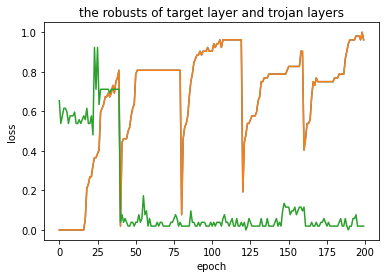

In [34]:
plt.plot(loss_per)
plt.plot(loss_rob_target)
plt.plot(loss_rob_trojan)
plt.title("the robusts of target layer and trojan layers")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()

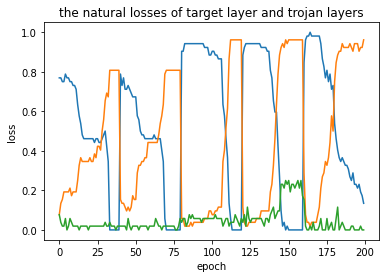

In [35]:
plt.plot(loss_mask)
plt.plot(loss_nat_target)
plt.plot(loss_nat_trojan)
plt.title("the natural losses of target layer and trojan layers")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()

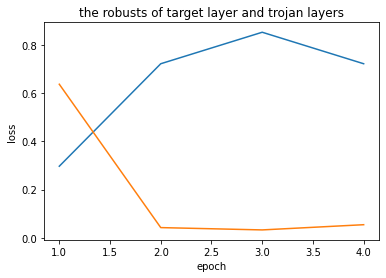

In [37]:
plt.plot(robust_target)
plt.plot(robust_trojan)
plt.title("the robusts of target layer and trojan layers")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()

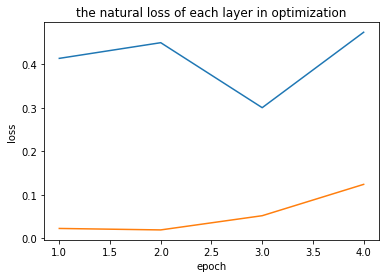

In [28]:
plt.plot(natural_target)
plt.plot(natural_trojan)
plt.title("the natural losses of target layer and trojan layers")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()

In [39]:
print(loss_sequential_1)
print(loss_sequential_2)

[nan, nan, 0.39057692307692304, 0.5045192307692308, 0.4110576923076924]
[nan, nan, 0.1455769230769231, 0.023846153846153875, 0.04807692307692309]
